## 文本情感倾向分类
现有旅游评论样本中,已带有情感倾向评论10086条(以星级评价划分情感倾向,5星标记为正向评价，3~4星标记为中性评价，1~2星标记为负向评价),另有近五千条评论无星级评价;现使用该1w+样本训练文本正负向情感分类器,为剩下的无星级评价评论进行情感正负向分类.


### 法一 
参考blog
[使用python和sklearn的中文文本多分类实战开发-派神-](https://blog.csdn.net/weixin_42608414/article/details/88046380)

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
import jieba as jb
import re

### 1. 加载文本数据

In [2]:
df = pd.read_excel('./data/迪士尼主题2021/comments.xlsx',sheet_name = '正负样本')
df=df[['cat','review']]
print("数据总量: %d ." % len(df))
df.sample(10)

数据总量: 10086 .


,cat,review
5324,POS,五一前去的人还不是很多，下雨天也阻挡不了出游的步伐，哈哈。
1375,POS,迪士尼的童话世界，还是购物村，玩乐购物一站齐
141,POS,景色不错，有趣好玩，性价比高，总体超赞，有机会还会来的......................
4752,POS,值得推荐，
2942,POS,总体超赞，
1760,POS,门票挺贵的&#x20;但是很值得........
1633,POS,非常不错的地方，非常不错的。很好。有趣
8398,NEG,绝对相信这是个高仿版的迪士尼，是迪士尼团队最大的决策失误。各方面太糟糕，不想多说，迪士尼fa...
5620,POS,有趣好玩，性价比高，景色不错，总体超赞，很好很满意，赞赞赞！
751,POS,现在携程旅行服务越来越好，希望票价再降一点吧


In [3]:
print("在 cat 列中总共有 %d 个空值." % df['cat'].isnull().sum())
print("在 review 列中总共有 %d 个空值." % df['review'].isnull().sum())
df[df.isnull().values==True]
df = df[pd.notnull(df['review'])]

在 cat 列中总共有 0 个空值.
在 review 列中总共有 0 个空值.


In [4]:
df_cat = df['cat'].value_counts().to_frame().reset_index().rename(columns={'index':'cat','cat':'num'})
df_cat

,cat,num
0,POS,8271
1,NEG,1815


### 2. 评论文本预处理

#### 给正负向情感标签编码
Pandas .factorize()方法通过标识不同的值来帮助获得数组的数字表示形式。

In [5]:
df['cat_id'] = df['cat'].factorize()[0]
cat_id_df = df[['cat', 'cat_id']].drop_duplicates().sort_values('cat_id').reset_index(drop=True)
cat_to_id = dict(cat_id_df.values)
id_to_cat = dict(cat_id_df[['cat_id', 'cat']].values)
df.sample(10)

,cat,review,cat_id
9128,NEG,买了7个项目快速通道，早上5：30让抵达，排队早享票&#x20;冲抵了3项快速通道项目。行程...,1
6630,POS,我挑的这一天天气特别好，空气质量也是棒棒哒！迪士尼白天和夜晚的景色都很赞，且大多数的游乐项目...,0
3371,POS,景色不错，有趣好玩，性价比高，总体超赞，超喜欢迪士尼，棒棒哒,0
5953,POS,比去现场买省时省力很多，太划算了,0
1161,POS,景色优美，很有趣的地方，孩子玩的很开心，下次还会去的！,0
5958,POS,有趣好玩，总体超赞，,0
1067,POS,开园短短几年，看看入园率就知道有多受欢迎。孩子们的欢乐世界。,0
7649,POS,迪士尼攻略：&#x0A;前一天订好闹钟，根据住宿距离检票口远近合理规划时间。基本上7.00就...,0
3045,POS,总体超赞，,0
5727,POS,很不错就是人有点多,0


In [6]:
cat_id_df

,cat,cat_id
0,POS,0
1,NEG,1


#### 停用词、分词处理

In [7]:
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line
 
def stopwordslist(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]  
    return stopwords  
 
#加载停用词
stopwords = stopwordslist("./data/stopwords.txt")

In [8]:
#删除除字母,数字，汉字以外的所有符号
df['clean_review'] = df['review'].apply(remove_punctuation)
df.sample(10)

,cat,review,cat_id,clean_review
7260,POS,原以为这是小孩子的天堂，进入园区才发现动画的杀伤力老少通吃，特别是花车巡游的音乐响起时，全场...,0,原以为这是小孩子的天堂进入园区才发现动画的杀伤力老少通吃特别是花车巡游的音乐响起时全场爆燃飞...
2129,POS,最大的提升的，孩子们非常喜欢。,0,最大的提升的孩子们非常喜欢
2014,POS,要的特别好，非常好玩的滋味！哈哈,0,要的特别好非常好玩的滋味哈哈
4707,POS,体验很好，景色不错，值得推荐，,0,体验很好景色不错值得推荐
1424,POS,交通便利，地铁直达，带小朋友玩耍的好去处。,0,交通便利地铁直达带小朋友玩耍的好去处
1542,POS,这里还是挺好玩的，值得去玩一趟，。。。？,0,这里还是挺好玩的值得去玩一趟
156,POS,第三次去迪士尼乐园，却是第一次和娃他爸两个人约会😜周日人不算太多，刷了八个项目，期间吃了两顿...,0,第三次去迪士尼乐园却是第一次和娃他爸两个人约会周日人不算太多刷了八个项目期间吃了两顿饭还去小...
8280,NEG,你们赢了，真是服了你们，这种事也做的出，下次绝对不会在你们这买任何东西。,1,你们赢了真是服了你们这种事也做的出下次绝对不会在你们这买任何东西
3685,POS,总体超赞，,0,总体超赞
7764,POS,携程就是给力，经常搞活动推出一些特价票，很划算，迪士尼真是什么时候人都超多，先安检再刷门票的...,0,携程就是给力经常搞活动推出一些特价票很划算迪士尼真是什么时候人都超多先安检再刷门票的如果带小...


In [9]:
#分词，并过滤停用词
df['cut_review'] = df['clean_review'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
df.head()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\lenovo\AppData\Local\Temp\jieba.cache
Loading model cost 0.967 seconds.
Prefix dict has been built successfully.


,cat,review,cat_id,clean_review,cut_review
0,POS,🍀入园前注意事项：&#x0A;入园需要携带身份证，查验绿色预约码（购票后卖方会发送含购票确认...,0,入园前注意事项x0A入园需要携带身份证查验绿色预约码购票后卖方会发送含购票确认码的短信根据指...,入园 前 注意事项 入园 携带 身份证 查验 绿色 预约 码 购票 卖方 发送 含 购票 确...
1,POS,鄙人迪士尼也算是去过一次了😆&#x0A;赶紧写下这个美丽的童话世界游玩攻略！&#x0A;&#...,0,鄙人迪士尼也算是去过一次了x0A赶紧写下这个美丽的童话世界游玩攻略x0Ax0A写在前头的总结...,迪士尼 算是 去过 赶紧 写下 美丽 童话世界 游玩 攻略 写 前头 值得 女生 不用说 直...
2,POS,首先原谅我私心重放这么多自己的照片，因为我觉得迪士尼真的太好出片了☺️一些项目和攻略照在后面...,0,首先原谅我私心重放这么多自己的照片因为我觉得迪士尼真的太好出片了一些项目和攻略照在后面大家可...,原谅 私心 重 放 照片 迪士尼 真的 太好 出片 项目 攻略 翻翻 游玩 路线 第一天 拍...
3,POS,上海迪士尼乐园，时间安排统计：&#x0A;地铁11号线迪士尼站，早上八点抵达，40分钟排队，...,0,上海迪士尼乐园时间安排统计x0A地铁11号线迪士尼站早上八点抵达40分钟排队拿到票出示上海随...,上海 迪士尼 乐园 时间 安排 统计 地铁 11 号线 迪士尼 站 早上 八点 抵达 40 ...
4,POS,2021.1.9&#x0A;Owen人生第一次去迪士尼，&#x0A;5岁的他走了25000步...,0,202119x0AOwen人生第一次去迪士尼x0A5岁的他走了25000步x0A去了十几次厕...,202119x0AOwen 人生 第一次 迪士尼 x0A5 岁 走 25000 步 十几次 ...


### 3. 初步分析
#### Top N 词云

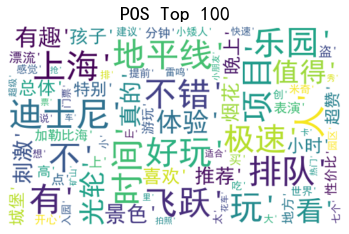

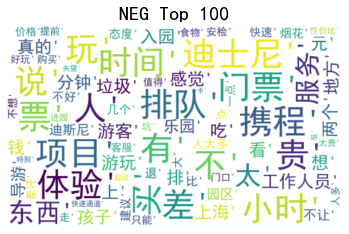

In [10]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(tup):
    wordcloud = WordCloud(background_color='white',
                          font_path='simhei.ttf',
                          width=500, height=300,
                          max_words=80, max_font_size=50,
                          random_state=50
                         ).generate(str(tup))
    return wordcloud
 
cat_desc = dict()
for cat in cat_id_df.cat.values: 
    text = df.loc[df['cat']==cat, 'cut_review']
    text = (' '.join(map(str,text))).split(' ')
    cat_desc[cat]=text

    most100=Counter(cat_desc[cat]).most_common(100)
    wordcloud = generate_wordcloud(most100)
    plt.figure()
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis("off")
    plt.title("{} Top 100".format(cat), fontsize=20)
    plt.show()
    wordcloud.to_file('output\\'+cat+"_wordcloud.png")

#### 简易主题分析
计算分词处理后评论文本的**TF-IDF**特征值。TF-IDF（term frequency–inverse document frequency）是一种用于信息检索与数据挖掘的常用加权技术。<br>
TF意思是**词频**(Term Frequency)，IDF意思是**逆文本频率指数**(Inverse Document Frequency)。TF-IDF是在单词计数的基础上，降低了常用高频词的权重,增加罕见词的权重；其思路为罕见词更能表达文章的主题思想。<br>
以下使用**sklearn.feature_extraction.text.TfidfVectorizer**方法来抽取文本的TF-IDF的特征值。<br>
这里我们使用了参数ngram_range=(1,2),这表示我们除了抽取评论中的每个词语外,还要抽取每个词相邻的词并组成一个“词语对”,如: 词1，词2，词3，词4，(词1，词2)，(词2,词3)，(词3，词4)。这样就扩展了我们特征集的数量,有了丰富的特征集才有可能提高我们分类文本的准确度。参数norm='l2'表示L2归一化处理。

TfidfTransformer和 CountVectorizer 都常用来构建词向量。
* CountVectorizer是通过fit_transform函数将文本中的词语转换为词频矩阵，矩阵元素a[i][j] 表示j词在第i个文本下的词频。
* TfidfTransformer用于统计vectorizer中每个词语的TF-IDF值

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
 
tfidf = TfidfVectorizer(norm='l2', ngram_range=(1, 2))
features = tfidf.fit_transform(df.cut_review)
labels = df.cat_id
print(features.shape)
print('-----------------------------')
print(features)

(10086, 174644)
-----------------------------
  (0, 118462)	0.04284693888980152
  (0, 144460)	0.03872549775224788
  (0, 52617)	0.033783981131777954
  (0, 162060)	0.03517904629620657
  (0, 81330)	0.03560774788862553
  (0, 58818)	0.04284693888980152
  (0, 70788)	0.04284693888980152
  (0, 159600)	0.04102317213295394
  (0, 124215)	0.032720713327707485
  (0, 169540)	0.03872549775224788
  (0, 127154)	0.03721205832803923
  (0, 18174)	0.04284693888980152
  (0, 64924)	0.04284693888980152
  (0, 29311)	0.04284693888980152
  (0, 142737)	0.04284693888980152
  (0, 88918)	0.04284693888980152
  (0, 134466)	0.04102317213295394
  (0, 109570)	0.03560774788862553
  (0, 161435)	0.04284693888980152
  (0, 42562)	0.037905422269331586
  (0, 71636)	0.04102317213295394
  (0, 64935)	0.04284693888980152
  (0, 51632)	0.04284693888980152
  (0, 173702)	0.04284693888980152
  (0, 64961)	0.04102317213295394
  :	:
  (10085, 34850)	0.07013076121808008
  (10085, 72515)	0.08270467316934743
  (10085, 92067)	0.080465658794224

我们看到我们的features的维度是(10086, 174644),这里的10086表示我们总共有10086条评价数据，174644表示我们的特征数量这包括全部评论中的所有词语数+词语对(相邻两个单词的组合)的总数。

下面使用**卡方检验**找出每个分类中关联度最大的两个词语和两个词语对。<br>
卡方检验是一种统计学的工具,用来检验数据的拟合度和关联度。在这里我们使用sklearn中的chi2方法。


In [12]:
from sklearn.feature_selection import chi2
import numpy as np
 
N = 3
for cat, cat_id in sorted(cat_to_id.items()):
    features_chi2 = chi2(features, labels==cat_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(cat))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'NEG':
  . Most correlated unigrams:
       . 好玩
       . 有趣
       . 垃圾
  . Most correlated bigrams:
       . 总体 超赞
       . 景色 不错
       . 有趣 好玩


D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'POS':
  . Most correlated unigrams:
       . 好玩
       . 有趣
       . 垃圾
  . Most correlated bigrams:
       . 总体 超赞
       . 景色 不错
       . 有趣 好玩


### 4. 模型选择
测试以下不同机器学习模型表现：
* Logistic Regression(逻辑回归)
* Random Forest(随机森林)
* (Multinomial) Naive Bayes(多项式朴素贝叶斯)
* Linear Support Vector Machine(线性支持向量机)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
 
from sklearn.model_selection import cross_val_score
 
models = [
    RandomForestClassifier(n_estimators=200, max_depth=10, random_state=0),
    LinearSVC(),
    SVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5 # 5折交叉验证
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

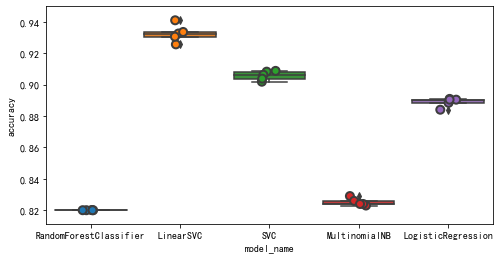

In [14]:
import seaborn as sns
 
plt.figure(figsize=(8, 4))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.savefig('output/文本分类模型选择.png',dpi=300)
plt.show()

In [15]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.932680
LogisticRegression        0.888856
MultinomialNB             0.825203
RandomForestClassifier    0.820048
SVC                       0.905810
Name: accuracy, dtype: float64

**LinearSVC**模型平均准确率最高（93.27%），其次是SVC模型（准确率90.58%）、逻辑回归（准确率88.89%）。下文采用LinearSVC建模。

### 5. 建模及评估

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC

clf = LinearSVC(max_iter=5)
#X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, 
#                                                                                         stratify=labels, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(df['cut_review'], df['cat_id'], test_size=0.3, random_state = 1874)
count_vect = CountVectorizer() 
X_train_counts = count_vect.fit_transform(X_train) # 将文本中的词语转换为词频矩阵
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts) #将词频矩阵统计成TF-IDF值
 
clf.fit(X_train_tfidf, y_train)

D:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC(max_iter=5)

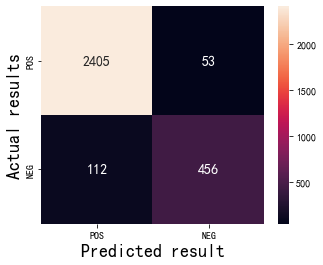

In [20]:
#生成混淆矩阵
y_pred = clf.predict(count_vect.transform(X_test))

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={'size':14},
            xticklabels=cat_id_df.cat.values, yticklabels=cat_id_df.cat.values)
plt.ylabel('Actual results',fontsize=18)
plt.xlabel('Predicted result',fontsize=18)
plt.savefig('output/混淆矩阵.png',dpi=300)
plt.show()

In [22]:
from sklearn.metrics import accuracy_score, classification_report

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=cat_id_df['cat'].values))

accuracy 0.9454725710508922
              precision    recall  f1-score   support

         POS       0.96      0.98      0.97      2458
         NEG       0.90      0.80      0.85       568

    accuracy                           0.95      3026
   macro avg       0.93      0.89      0.91      3026
weighted avg       0.94      0.95      0.94      3026



#### 模型保存

In [32]:
import joblib
joblib.dump(model,'output/model_sentiment.pkl')

['output/model_sentiment.pkl']

### 6. 预测无标签样本
标记无星级评价的评论文本样本

In [24]:
def myPredict(sec):
    format_sec=" ".join([w for w in list(jb.cut(remove_punctuation(sec))) if w not in stopwords])
    pred_cat_id=clf.predict(count_vect.transform([format_sec]))
    pre = id_to_cat[pred_cat_id[0]]
    return pre

In [25]:
string='迪士尼啊！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！全球最顶尖的主题公园游园体验了，我一个人来的，单人票，里面很贴心的有单人游客通道，因为迪士尼大部分都是三五成群来玩的，所以很多项目会有一个'    
myPredict(string)

'POS'

In [27]:
df2 = pd.read_excel('data\迪士尼主题2021\comments.xlsx',sheet_name = '无标签')
print("待预测数据总量: %d ." % len(df2))
df2.head()

待预测数据总量: 4687 .


,review
0,去上迪每次都会拍好多照片，而且感觉永远也拍不完！因为真的太！好！玩！啦！ 哈哈又是和李女士蹦...
1,迪士尼告诉我们：你可以相信童话！\n必玩项目：【创极速光轮】人在前面跑魂在后面追一点都不假、...
2,「奇幻童话城堡」「翱翔•飞跃地平线」「抱抱龙冲天赛车」「冰雪奇缘-欢唱盛会」「金色童话盛典」...
3,非常的无语，都说迪士尼是守护大家的童年梦，可是现实根本没那么回事。里面的大部分工作人员都是板...
4,明日世界没体验有点怕。其他的一个没有落下，感觉海盗最有意思。时间对比比其他的要久一点。20....


In [28]:
# 给无标签样本分类正负向情感
df2['cat'] = df2['review'].apply(lambda x: myPredict(x))
df2

,review,cat
0,去上迪每次都会拍好多照片，而且感觉永远也拍不完！因为真的太！好！玩！啦！ 哈哈又是和李女士蹦...,POS
1,迪士尼告诉我们：你可以相信童话！\n必玩项目：【创极速光轮】人在前面跑魂在后面追一点都不假、...,POS
2,「奇幻童话城堡」「翱翔•飞跃地平线」「抱抱龙冲天赛车」「冰雪奇缘-欢唱盛会」「金色童话盛典」...,POS
3,非常的无语，都说迪士尼是守护大家的童年梦，可是现实根本没那么回事。里面的大部分工作人员都是板...,POS
4,明日世界没体验有点怕。其他的一个没有落下，感觉海盗最有意思。时间对比比其他的要久一点。20....,POS
...,...,...
4682,总体评分还是给了三颗星，最主要还是因为超超超级多的游客导致的！这一点和国外的迪士尼完全不同，...,POS
4683,一定要去（最好避开节假日），而且最好能买早享卡，这样会节约很多排队时间。 在迪士尼，每个女生...,POS
4684,上海迪士尼乐园是中国内地首座迪士尼主题乐园，人真的超级多，早上七点半左右去排的队，大概九点入...,POS
4685,乐园还算大，带着四五岁的孩子要玩两天。当然里面的消费真的很贵，两个包子要70块钱。我是六月份...,NEG


In [29]:
df2.cat.value_counts()

POS    4192
NEG     495
Name: cat, dtype: int64

上文以正负向情感二分类为例，文本多分类同理，例如正中负向、细分情感倾向分类等。

### 法二
### 中文在线评论的情感分析

文本情感分析，又称意见挖掘（Opinion Mining），是指对带有情感色彩的主观性文本进行分析、处理、归纳和推理的过程；属于计算语言学的范畴，涉及到人工智能、机器学习、数据挖掘、信息检索、自然语言处理等多个研究领域。情感极性分析的目的是对文本进行褒义、贬义、中性的判断。在大多应用场景下，只分为两类。

现阶段主要的情感分析方法主要有两类：基于词典的方法和基于机器学习的方法。基于词典的方法主要通过制定一系列的情感词典和规则，对文本进行段落拆借、句法分析，计算情感值，最后通过情感值来作为文本的情感倾向依据。基于机器学习的方法大多将这个问题转化为一个分类问题来看待，对于情感极性的判断，将目标情感分类2类：正、负。对训练文本进行人工标标注，然后进行有监督的机器学习过程。例如想在较为常见的基于大规模语料库的机器学习等。

In [30]:
# -*- coding: utf-8 -*-
from sklearn.model_selection import train_test_split
from gensim.models.word2vec import Word2Vec  #构造词向量
import numpy as np
import pandas as pd
import jieba
import joblib   #模型持久化
from sklearn.svm import SVC


In [33]:
# 加载文件，导入数据,分词
def loadfile():
    neg=pd.read_excel('data/迪士尼主题2021/NEG.xlsx',header=None)  #正面文件  index=None
    pos=pd.read_excel('data/迪士尼主题2021/POS.xlsx',header=None)  #负面文件
    neu=pd.read_excel('data/迪士尼主题2021/NEU.xlsx',header=None)  #中性文件

    cw = lambda x: list(jieba.cut(x))    #构造分词函数，了解lambda语法、作用
    pos['words'] = pos[0].apply(cw)      #执行分词，了解apply的价值作用
    neg['words'] = neg[0].apply(cw)
    neu['words'] = neu[0].apply(cw)

    #print(pos['words'])
    #use 1 for positive（正面，积极的） sentiment, -1 for negative（负面，消极的） 0for 中立的
    y = np.concatenate((np.ones(len(pos)), np.zeros(len(neu)),np.full(len(neg), 2))) #构造标记值y,由concatenate合并正、负语料数得到
 #full函数创建一个填充给定值的n * n数组，若第一个元素仅为一个数字，则表示一行n列
    x_train, x_test, y_train, y_test = train_test_split(np.concatenate((pos['words'], neu['words'],neg['words'])), y, test_size=0.2) # test_size测试集比例
    
    np.save('output/y_train.npy',y_train)   #将训练标记存储起来，以备后用
    np.save('output/y_test.npy',y_test)     
    return x_train,x_test      #返回训练集和测试集数据

    
#计算词向量
def get_train_vecs(x_train,x_test):
    n_dim = 300  
    #初始化词向量模型和构建词汇表
    my_w2v = Word2Vec(size=n_dim, min_count=10)  #size特征向量的维数，min_count小于该词频数单词将被抛弃
    my_w2v.build_vocab(x_train)                  #构建词汇表
    
    #在训练集上训练模型（这可能需要几分钟的时间）
    my_w2v.train(x_train,total_examples=my_w2v.corpus_count, epochs=my_w2v.iter)  ##iter: 随机梯度下降法中迭代的最大次数，默认是5。
    
    train_vecs = np.concatenate([buildWordVector(z, n_dim,my_w2v) for z in x_train])
    #train_vecs = scale(train_vecs)
    
    np.save('output/train_vecs.npy',train_vecs)
    print(train_vecs.shape)
    #Train word2vec on test tweets
    my_w2v.train(x_test,total_examples=my_w2v.corpus_count, epochs=my_w2v.iter)
    my_w2v.save('output/w2v_model.pkl')
    #Build test tweet vectors then scale
    test_vecs = np.concatenate([buildWordVector(z, n_dim,my_w2v) for z in x_test])
    #test_vecs = scale(test_vecs)
    np.save('output/test_vecs.npy',test_vecs)
    print(test_vecs.shape)

#对每个句子的所有词向量取均值
def buildWordVector(text, size,my_w2v):
    #text：一条文本，size一个词向量维度，my_w2v训练好的词向量
    vec = np.zeros(size).reshape((1, size)) #初始一个1行size列的向量
    count = 0.
    for word in text:
        try:
            vec += my_w2v[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count  #求均值
    return vec

#获取已保存的中间数据
def get_data():
    train_vecs=np.load('output/train_vecs.npy')
    y_train=np.load('output/y_train.npy')
    test_vecs=np.load('output/test_vecs.npy')
    y_test=np.load('output/y_test.npy') 
    return train_vecs,y_train,test_vecs,y_test

##训练svm模型
def svm_train(train_vecs,y_train,test_vecs,y_test):
    clf=SVC(kernel='rbf',verbose=True)
    clf.fit(train_vecs,y_train)
    joblib.dump(clf, 'output/svm_model.pkl') #保存训练好的模型
    print(clf.score(test_vecs,y_test))    #输出模型评估
    
##得到待预测单个句子的词向量    
def get_predict_vecs(words):
    n_dim = 300
    my_w2v = Word2Vec.load('output/w2v_model.pkl')
    #从训练好的模型my_w2v中获得句子words的平均词向量
    train_vecs = buildWordVector(words, n_dim,my_w2v) 

    return train_vecs
    
####对单个句子进行情感判断    
def svm_predict(string):
    words=jieba.lcut(string)
    words_vecs=get_predict_vecs(words)
    clf=joblib.load('output/svm_model.pkl')
     
    result=clf.predict(words_vecs)
    
    if int(result[0])==1:
        print(string,' positive')
    if int(result[0])==-1:
        print(string,' negative')
    else:
        print(string,' neutral')

#### 1、理解数据加载与预处理

In [34]:
#导入文件，处理保存为向量
x_train,x_test=loadfile()   #得到句子分词后的结果，并把类别标签保存为y_train.npy,y_test.npy

In [35]:
#示例，获取第一条训练样本，其中第一个词，注意是unicode编码
print(x_train[0])
print(x_train[0][0])

['超级', '好玩', '\xa0', '&#', 'x20', ';', '但', '当时', '去', '的', '人', '还是', '算蛮', '多', '的', '\xa0', '&#', 'x20', ';', '所以', '有些', '项目', '还', '没有', '都', '玩', '过', '一遍', '\xa0', '&#', 'x20', ';', '下次', '还要', '去', '把', '没有', '玩过', '的', '都', '玩', '一遍', '&#', 'x20', ';', '迪士尼', '的', '烟花', '真的', '是', '值得一看']
超级


In [36]:
for w in x_train[0]: 
    print(w,end='')   #print(w,end='')

超级好玩 &#x20;但当时去的人还是算蛮多的 &#x20;所以有些项目还没有都玩过一遍 &#x20;下次还要去把没有玩过的都玩一遍&#x20;迪士尼的烟花真的是值得一看

#### 2、理解词向量

In [37]:
#初步构造词向量模型
n_dim = 300  ##三百维的向量表示一个词的权重（训练得出）
my_w2v = Word2Vec(size=n_dim, min_count=10)  #size特征向量的维数，min_count小于该词频数将被抛弃
my_w2v.build_vocab(x_train)                  #构建词汇表

In [38]:
??Word2Vec     # 参数详解 http://blog.csdn.net/mrynr/article/details/52983038

Object `Word2Vec     # 参数详解 http://blog.csdn.net/mrynr/article/details/52983038` not found.


In [39]:
#训练词向量模型
my_w2v.train(x_train,total_examples=my_w2v.corpus_count, epochs=my_w2v.iter)  #训练，更新神经网络的权重

D:\Anaconda\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  from ipykernel import kernelapp as app


(2118879, 3252510)

In [40]:
#获取训练语料的词向量
train_vecs = np.concatenate([buildWordVector(z, n_dim,my_w2v) for z in x_train])

D:\Anaconda\lib\site-packages\ipykernel\__main__.py:54: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [41]:
#理解第一条训练文本的词向量
avec=buildWordVector(x_train[0], n_dim,my_w2v)
print(len(avec[0]),avec)

300 [[-2.72866468e-01  1.92975881e-01 -8.40951474e-02  1.32780628e-01
  -1.47415416e-01 -1.69265891e-01  5.62648740e-02 -8.62754316e-02
  -4.63717819e-01 -1.54486508e-01  3.30933051e-01 -2.37743832e-01
   8.72723824e-02  2.55569777e-03  3.76683523e-02 -7.53461409e-02
   1.40507669e-01  4.53584941e-02 -6.87312574e-02  7.74170136e-02
   2.34804439e-01 -6.79281889e-03  1.27057429e-01  7.71915167e-02
   3.30588827e-02  8.49398738e-02  3.43760318e-01 -2.49813505e-01
   1.61320350e-01  2.14473470e-01  3.37965488e-01  1.22184383e-02
  -1.20897563e-01  1.36482466e-01 -6.65239680e-02  1.81298203e-02
   5.80847167e-02 -1.48812326e-01 -3.28624792e-01 -2.91984670e-03
  -1.64289303e-01 -9.01383477e-02  1.38341501e-03 -5.93159934e-02
   1.97494064e-02  5.02669824e-03 -6.57195019e-02 -2.52779822e-01
  -2.49463871e-01  1.61047820e-01  2.55319346e-02 -1.78173144e-01
  -3.01793257e-01 -3.66994498e-02  1.81012639e-01 -1.69414763e-01
  -1.26730224e-02  1.23347377e-01 -1.03614791e-01 -5.58841885e-02
  -1.6

D:\Anaconda\lib\site-packages\ipykernel\__main__.py:54: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [42]:
#理解第一条训练文本中每个词的词向量
vec = np.zeros(300).reshape((1, 300))
count = 0.
for word in x_train[0]:
    print(word,'\n')
    try:
        print(len(my_w2v[word]),my_w2v[word],'\n')
        vec += my_w2v[word].reshape((1, 300))
        count += 1.
    except KeyError:
          continue
if count != 0:
    vec /= count


超级 

300 [ 0.2681629  -0.37626687 -0.3129773  -0.03809885 -0.5002238  -0.15339735
  0.6724404  -0.07675172 -0.43156597 -0.40384337  0.07761406 -0.52150255
  0.44574553 -0.14062841 -0.7160386  -0.13913977  0.32897988  0.18406686
 -0.29195863 -0.47979006 -0.26253152  0.12008297  0.51580924  0.50942814
 -0.04084738  0.8418041   0.57178813 -0.43932804  0.29241335  0.5283962
 -0.1349704  -0.50850403  0.91278386  0.15681538  0.1316218   0.3445714
 -0.27638513  0.03411845  0.37321895 -0.30241048  0.0853351  -0.4345254
  0.09685252 -0.49844807 -0.31299436  0.12241103 -0.20016223  0.3141433
  0.0742909   0.4709489   0.3245992  -0.4747022  -0.4654199  -0.33053967
  0.2198483   0.03615519  0.8239103   0.1318396   0.8600785   0.37590808
 -0.00399227 -0.18236311  0.2403256  -0.6398038   0.03209694  0.68873036
 -0.02053823 -0.17233112 -0.10119047 -0.20844054 -0.4973551  -0.26366472
 -0.64357567 -0.82541233 -0.55690765  0.076199   -0.4142704  -0.02177863
 -0.09246258 -0.11672039 -0.49827826  1.256640

D:\Anaconda\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
D:\Anaconda\lib\site-packages\ipykernel\__main__.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


#### 3、进行SVM训练与预测

In [43]:
x_train,x_test=loadfile()
get_train_vecs(x_train,x_test)                   #计算词向量并保存为train_vecs.npy,test_vecs.npy
train_vecs,y_train,test_vecs,y_test=get_data()   #导入保存的训练数据和测试数据
svm_train(train_vecs,y_train,test_vecs,y_test)   #训练svm并保存模型

D:\Anaconda\lib\site-packages\ipykernel\__main__.py:31: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
D:\Anaconda\lib\site-packages\ipykernel\__main__.py:54: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


(9253, 300)


D:\Anaconda\lib\site-packages\ipykernel\__main__.py:39: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
D:\Anaconda\lib\site-packages\ipykernel\__main__.py:54: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


(2314, 300)
[LibSVM]0.8150388936905791


In [44]:
##对输入句子情感进行判断s
tring='迪士尼啊！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！全球最顶尖的主题公园游园体验了，我一个人来的，单人票，里面很贴心的有单人游客通道，因为迪士尼大部分都是三五成群来玩的，所以很多项目会有一个'    
svm_predict(string)

迪士尼啊！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！全球最顶尖的主题公园游园体验了，我一个人来的，单人票，里面很贴心的有单人游客通道，因为迪士尼大部分都是三五成群来玩的，所以很多项目会有一个  neutral


D:\Anaconda\lib\site-packages\ipykernel\__main__.py:54: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [45]:
string='这样的烂手机，真不知道说啥好了！'    
svm_predict(string)

这样的烂手机，真不知道说啥好了！  neutral


D:\Anaconda\lib\site-packages\ipykernel\__main__.py:54: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


综合表现不及法一的模型。